## Isolation Forest trials
Into the forest, forget to sleep. 

In [189]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
import io
import requests
import keyring as kr

In [190]:
# define functions:
def eio_hist(key, node_id, start_time, end_time=datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')):
    
    url = "https://api.eagle.io/api/v1/historic/?params="+node_id+"&startTime="+start_time+"&endTime="+end_time+"&qualityExcluded=NONE"
    headers = {'X-Api-Key':key, 'Content-Type':"application/json"}

    r = requests.get(url=url, headers=headers)
    x = r.json()

    df = pd.DataFrame(x['data'])
    normalized_data = pd.json_normalize(df['f'])

    # Replacing the 'f' column in the original DataFrame with the normalized data
    df.drop(columns='f', inplace=True)  # Drop the existing 'f' column
    df = pd.concat([df, normalized_data], axis=1)  # Concatenate the normalized data

    #extract the name of the column from the J
    var_name = x['header']['columns']['0']['name']
    # Renaming the column '0.v' to a new name, e.g., 'new_column_name'
    df = df.rename(columns={'0.v': var_name, '0.q': "quality"})
    # Convert the 'ts' column to datetime with milliseconds
    df['ts'] = pd.to_datetime(df['ts'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    # return the updated DataFrame
    return(df)


def silo_grid(lat, long, start, format = "standard", username = "example@email.com", finish = datetime.now().strftime('%Y%m%d')):
    if finish is None:
        finish = datetime.datetime.now() + datetime.timedelta(days=1)
    #create request URL:
    url = "https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?lat="+lat+"&lon="+long+"&start="+start+"&finish="+finish+"&format="+format+"&comment=no&username="+username+"&password=apirequest"
    r = requests.get(url)
    r.raise_for_status()
    data = r.text

    # Find the index where the data starts
    start_idx = data.find('Date')

    # Skip first row and create a string buffer with the data
    data_to_read = io.StringIO(data[start_idx:])

    # Read the data into a DataFrame
    df = pd.read_csv(data_to_read, delim_whitespace=True)
    #join column names and first row to include units
    new_column_names = np.array(df.columns) + np.array(df.iloc[0])
    #rename columns
    df.columns = new_column_names
    # Drop the first row
    df = df.drop(0)
    df['Date(yyyymmdd)'] = pd.to_datetime(df['Date(yyyymmdd)'], format="%Y%m%d")
    # Convert specific columns to numeric
    cols_to_convert = [
        'Day()', 'T.Max(oC)', 'Smx()', 'T.Min(oC)', 'Smn()', 'Rain(mm)', 'Srn()', 'Evap(mm)',
        'Sev()', 'Radn(MJ/m2)', 'Ssl()', 'VP(hPa)', 'Svp()', 'RHmaxT(%)', 'RHminT(%)'
    ]
    # Convert columns to numeric
    df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')
    return(df)

In [191]:
key = kr.get_password("eagleIO_API", "CR_readonly")
MRD_nox = "5e718f44183a870cb2b16d2f"
MRD_Q = "5848d5da527032fe0c6a947d"
start_time = "2016-12-08T00:00:00Z"
end_time = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')

In [192]:
# build a dataset

nox = eio_hist(key= key, node_id= MRD_nox, start_time= start_time)
Q = eio_hist(key= key, node_id= MRD_Q, start_time= start_time)

silo = silo_grid(lat = "-17.2075", long = "145.92639",
    start = (datetime.now()- timedelta(3500)).strftime('%Y%m%d'), 
    format = "standard",
    username = "example@email.com.au",
    finish=datetime.now().strftime('%Y%m%d'))

In [193]:
# Merge DataFrames based on 'ts' column with left join
merged_df = pd.merge(nox, Q, on='ts', how='outer')

print(merged_df)

                            ts    TSS  quality_x  ADCP - ADCP Q  quality_y
0      2016-12-16 03:12:00.000   39.0       10.0            NaN        NaN
1      2017-01-07 14:23:00.000  151.0       10.0            NaN        NaN
2      2017-01-07 18:08:00.000   58.0       10.0            NaN        NaN
3      2017-01-07 19:38:00.000   39.0       10.0            NaN        NaN
4      2017-01-08 00:28:00.000   42.0       10.0            NaN        NaN
...                        ...    ...        ...            ...        ...
230003 2024-02-07 09:50:00.085    NaN        NaN         37.473        NaN
230004 2024-02-07 10:00:20.905    NaN        NaN         45.805        NaN
230005 2024-02-07 10:10:00.085    NaN        NaN         53.830        NaN
230006 2024-02-07 10:13:00.078    NaN        NaN         57.418        NaN
230007 2024-02-07 10:20:00.085    NaN        NaN         62.173        NaN

[230008 rows x 5 columns]


In [194]:
# Sort by 'ts' column
merged_df.sort_values(by='ts', inplace=True)
# Linearly interpolate NaN values in ADCP - ADCP Q column
merged_df['ADCP - ADCP Q'] = merged_df['ADCP - ADCP Q'].interpolate(method='linear')


In [195]:

# Convert 'ts' to the format of 'Date(yyyymmdd)' for matching
merged_df['day'] = pd.to_datetime(merged_df['ts']).dt.strftime('%Y%m%d')
silo['day'] = pd.to_datetime(silo['Date(yyyymmdd)']).dt.strftime('%Y%m%d')


In [196]:
# Merge with additional DataFrame
merged_df = pd.merge(merged_df, silo, on='day', how='outer')

# Fill NaN values in additional columns
additional_columns = ['Day()', 'T.Max(oC)', 'Smx()', 'T.Min(oC)', 'Smn()', 'Rain(mm)', 'Srn()', 'Evap(mm)', 'Sev()', 'Radn(MJ/m2)', 'Ssl()', 'VP(hPa)', 'Svp()', 'RHmaxT(%)', 'RHminT(%)']
merged_df[additional_columns] = merged_df[additional_columns].fillna(method='ffill')

In [197]:
# List of columns to drop
columns_to_drop = ['Date(yyyymmdd)', 'quality_x', 'quality_y', 'day', 'Date2(ddmmyyyy)', 'Day()', 'T.Max(oC)',	'Smx()',	'T.Min(oC)',	'Smn()',	'Srn()',	'Sev()',	'Radn(MJ/m2)',	'Ssl()',	'VP(hPa)',	'Svp()',	'RHmaxT(%)',	'RHminT(%)']

# Drop the columns
df = merged_df.drop(columns_to_drop, axis=1)

# Print the new DataFrame
print(df)


                        ts  TSS  ADCP - ADCP Q  Rain(mm)  Evap(mm)
0      2016-12-08 03:58:20  NaN        -42.611       0.9       9.5
1      2016-12-08 04:08:20  NaN        -37.826       0.9       9.5
2      2016-12-08 04:18:20  NaN        -42.448       0.9       9.5
3      2016-12-08 04:28:20  NaN        -49.155       0.9       9.5
4      2016-12-08 04:38:20  NaN        -53.296       0.9       9.5
...                    ...  ...            ...       ...       ...
230981                 NaT  NaN            NaN       0.0       5.6
230982                 NaT  NaN            NaN      19.9       5.2
230983                 NaT  NaN            NaN      12.0       3.0
230984                 NaT  NaN            NaN       0.0       8.3
230985                 NaT  NaN            NaN       0.0       8.5

[230986 rows x 5 columns]


In [198]:
# Drop rows with NaN in ژاد nitrogen column
df = df.dropna(subset=['TSS'])
df.head()


,ts,TSS,ADCP - ADCP Q,Rain(mm),Evap(mm)
615,2016-12-16 03:12:00,39.0,110.066,0.1,5.0
2319,2017-01-07 14:23:00,151.0,105.389,25.8,8.2
2324,2017-01-07 18:08:00,58.0,34.202,25.8,8.2
2334,2017-01-07 19:38:00,39.0,5.004,25.8,8.2
2364,2017-01-08 00:28:00,42.0,146.326,93.6,6.5


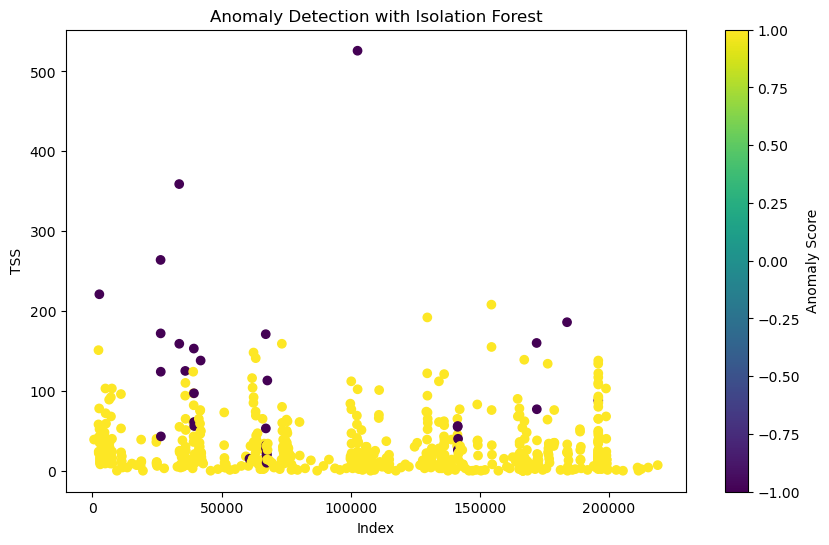

Anomalies:
          TSS  ADCP - ADCP Q  Rain(mm)  Evap(mm)  anomaly
2653    221.0     357.485500      79.0       6.3       -1
26364   264.0     266.826000      16.2       6.3       -1
26399   172.0     308.259000     234.8       1.8       -1
26434   124.0     280.559500     234.8       1.8       -1
26480    43.0     194.924500     234.8       1.8       -1
33571   359.0     207.269000      54.7       7.1       -1
33606   159.0     337.896000     207.6       4.0       -1
35925   125.0     304.914000     160.0       5.9       -1
39237   153.0     670.301500     135.1       3.5       -1
39291    97.0     830.205000     135.1       3.5       -1
39347    61.0     975.956000     142.8      12.0       -1
39403    56.0     890.777000     142.8      12.0       -1
41874   138.0     752.444500     103.6       4.5       -1
60786    15.0      23.721000       0.0      20.2       -1
67082   171.0     389.655500      25.6      12.2       -1
67125    53.0     505.903500      25.6      12.2       -1
671

In [199]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame df

# Drop the 'ts' column as it's not needed for the anomaly detection
df.drop(columns=['ts'], inplace=True)

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.05)  # Adjust contamination based on your dataset

# Fit the model on the DataFrame, considering 'Oxidised nitrogen' as the target variable
model.fit(df)

# Predict the anomalies
anomaly_labels = model.predict(df)

# Add anomaly labels to the DataFrame
df['anomaly'] = anomaly_labels

# Visualize the anomalies
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['TSS'], c=df['anomaly'], cmap='viridis')
plt.xlabel('Index')
plt.ylabel('TSS')
plt.title('Anomaly Detection with Isolation Forest')
plt.colorbar(label='Anomaly Score')
plt.show()

# Display the rows flagged as anomalies
anomalies = df[df['anomaly'] == -1]
print("Anomalies:")
print(anomalies)


In [200]:
# Create an interactive scatter plot with Plotly
fig = px.scatter(df, x=df.index, y='TSS', color='anomaly',
                 title='Anomaly Detection with Isolation Forest',
                 labels={'index': 'Index', 'TSS': 'TSS'},
                 color_continuous_scale='viridis',
                 range_color=[0, 1])

fig.update_layout(xaxis_title='Index', yaxis_title='TSS')

# Show the plot
fig.show()